<a href="https://colab.research.google.com/github/skourta/articulus_divisio/blob/main/DKM_DCN_tf_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
! pip install umap-learn
! gdown 'https://drive.google.com/uc?id=1zTDcgnFtQWUeXgIce4O2Z2OPn0vJH1aD'
! pip install transformers

     |████████████████████████████████| 86 kB 4.5 MB/s 
     |████████████████████████████████| 1.1 MB 33.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=9dd6bd14e4f248d52f2179d4f5c70b366c28b7d7249ba6745a75ac52abc56672
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=c94a027e5fac9b296c0c49239871c49591eb8be0d3aa1bba407e20e84e300664
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent
Downloading...
From: https://drive.google.com/uc?id=1zTDcgnFtQWUeXgIce4O2Z2OPn0vJH1aD
To: /content/utils_py.py
100% 6.69k/6.69k [00:00<00:00, 5.07MB/s]
     |████████████████████████████████| 3.1 MB 13.1 MB/s 
     |████████████████████████████████| 895 kB 37.5 MB/s 
     |████████████████████████████████| 3.3 

In [2]:
from gensim.models import KeyedVectors
import numpy as np
import h5py as h5
import re
import pandas as pd
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings
from umap import UMAP
from utils_py import accuracy

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Utils

## Algorithme de classification

In [4]:
import os
import math
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.cluster import KMeans
from tqdm import tqdm

In [5]:
TF_FLOAT_TYPE = tf.float32

tf.disable_eager_execution()

def fc_layers(input, specs):
    [dimensions, activations, names] = specs
    for dimension, activation, name in zip(dimensions, activations, names):
        input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)
    return input

def autoencoder(input, specs):
    [dimensions, activations, names] = specs
    mid_ind = int(len(dimensions)/2)

    # Encoder
    embedding = fc_layers(input, [dimensions[:mid_ind], activations[:mid_ind], names[:mid_ind]])
    # Decoder
    output = fc_layers(embedding, [dimensions[mid_ind:], activations[mid_ind:], names[mid_ind:]])

    return embedding, output

def f_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def g_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def next_batch(num, data):
    """
    Return a total of `num` random samples.
    """
    indices = np.arange(0, data.shape[0])
    np.random.shuffle(indices)
    indices = indices[:num]
    batch_data = np.asarray([data[i, :] for i in indices])

    return indices, batch_data

## Deep Clustering Network

In [6]:
class DcnCompGraph(object):
    """Computation graph for the Deep Clustering Network model proposed in:
        Yang, B., Fu, X., Sidiropoulos, N. D., & Hong, M. (2017). Towards K-means-friendly Spaces: Simultaneous Deep
        Learning and Clustering. In ICML '17 (pp. 3861–3870).
    This implementation is inspired by https://github.com/boyangumn/DCN
    """

    def __init__(self, ae_specs, n_clusters, batch_size, n_samples, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0]) - 1) / 2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(batch_size, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g
        self.ae_loss = tf.reduce_mean(rec_error)

        # Clustering loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## Clustering assignments for all samples in the dataset
        initial_clustering_assign = tf.random_uniform(minval=0, maxval=n_clusters, dtype=tf.int32, shape=[n_samples])
        self.cluster_assign = tf.Variable(initial_clustering_assign, name='cluster_assign', dtype=tf.int32, trainable=False)

        ## Get the cluster representative corresponding to the cluster of each batch sample
        self.indices = tf.placeholder(dtype=tf.int32, shape=batch_size)  # Placeholder for sample indices in current batch
        batch_clust_rep = []
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            batch_clust_rep.append(self.cluster_rep[k, :])
        stack_batch_clust_rep = tf.stack(batch_clust_rep)

        ## Compute the k-means term
        clustering_error = f_func(self.embedding, stack_batch_clust_rep)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(clustering_error)
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DCN
        self.train_op = optimizer.minimize(self.loss)

        # As it has been pointed out in the DCN paper, first the weights of the autoencoder shall be trained then the
        # assignments and cluster representatives. So far in the computation graph we have optimized the weights of the
        # autoencoder, now it's the time for the assignments and representatives.

        # Update the clustering assignments
        for j in range(batch_size):
            # Find which cluster representative is the closest to the current batch sample
            new_assign = tf.argmin(f_func(tf.reshape(self.embedding[j, :], (1, embedding_size)), self.cluster_rep),
                                   output_type=tf.int32)
            # Update the clustering assignment
            self.cluster_assign_update = tf.assign(self.cluster_assign[self.indices[j]], new_assign)

        # Update the cluster representatives
        ## Initialize the value of count
        initial_count = tf.constant(100.0, shape=[n_clusters])
        count = tf.Variable(initial_count, name='count', dtype=TF_FLOAT_TYPE, trainable=False)
        ## Update the cluster representatives according to Equation (8) in the DCN paper
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            self.count_update = tf.assign(count[k], count[k] + 1)  # Updated count for cluster assignments
            new_rep = self.cluster_rep[k] - (1 / count[k]) * (self.cluster_rep[k] - self.embedding[j])
            self.cluster_rep_update = tf.assign(self.cluster_rep[k], new_rep)

In [7]:
def DCN(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=50, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)

    cg = DcnCompGraph([dimensions, activations, names], n_clusters, batch_size, n_samples,
                      lambda_)

    # Run the computation graph
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):

                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices_, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                       feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices_)):
                        embeddings[indices_[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DCN
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

            # The clustering assignments are used to initialize the clustering assignments in DCN
            sess.run(tf.assign(cg.cluster_assign, kmeans_model.labels_))

        # Train the full DCN model
        print("Starting DCN training...")
        ## Loop over epochs
        for epoch in tqdm(range(n_finetuning_epochs)):
            # print("Training step: epoch {}".format(epoch))

            # Loop over the samples
            for _ in range(n_batches):
                # Fetch a random data batch of the specified size
                indices_, data_batch = next_batch(batch_size, data)

                # Run the computation graph on the data batch
                _, _, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                    sess.run((cg.train_op, cg.cluster_assign_update, cg.count_update, cg.cluster_rep_update, cg.loss,
                              cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                             feed_dict={cg.input: data_batch, cg.indices: indices_})
        
        embeddings = np.zeros((n_samples, embedding_size), dtype=float)
        for _ in range(n_batches):
            # Fetch a random data batch of the specified size
            indices_, data_batch = next_batch(batch_size, data)

            # Run the computation graph on the data batch
            _, _, embeddings_, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                sess.run((cg.train_op, cg.cluster_assign_update, cg.embedding, cg.count_update, cg.cluster_rep_update, cg.loss,
                          cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                          feed_dict={cg.input: data_batch, cg.indices: indices_})

            for j in range(len(indices_)):
                embeddings[indices_[j], :] = embeddings_[j, :]
                
    return embeddings, cluster_assign_


## Deep K-means

In [8]:
class DkmCompGraph(object):
    """Computation graph for Deep K-Means
    """

    def __init__(self, ae_specs, n_clusters, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0])-1)/2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(None, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g

        # k-Means loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## First, compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, n_clusters):
            dist = f_func(self.embedding, tf.reshape(self.cluster_rep[i, :], (1, embedding_size)))
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        ## Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(list_dist, axis=0)

        ## Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        self.alpha = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=())  # Placeholder tensor for alpha
        list_exp = []
        for i in range(n_clusters):
            exp = tf.exp(-self.alpha * (self.stack_dist[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)

        ## Fourth, compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = self.stack_dist[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(tf.reduce_sum(stack_weighted_dist, axis=0))
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DKM
        self.train_op = optimizer.minimize(self.loss) # Train the whole DKM model

In [9]:
def DKM(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    """
        The final number of finetuning epochs is n_finetuning_epochs * 20 if pretrain and n_finetuning_epochs * 40 if annealing
    """
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained
    annealing = False # Specify if annealing should be used

    # Define the alpha scheme depending on if the approach includes annealing/pretraining
    if annealing and not pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 40  # Number of alpha values to consider
        alphas = np.zeros(max_n, dtype=float)
        alphas[0] = 0.1
        for i in range(1, max_n):
            alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
        alphas = alphas / constant_value
    elif not annealing and pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 20  # Number of alpha values to consider (constant values are used here)
        alphas = 1000*np.ones(max_n, dtype=float) # alpha is constant
        alphas = alphas / constant_value
    else:
        raise Exception("Run with either annealing (-a) or pretraining (-p), but not both.")

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    config = tf.ConfigProto(gpu_options=gpu_options)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)
      
    # Define the computation graph for DKM
    cg = DkmCompGraph([dimensions, activations, names], n_clusters, lambda_)

    # Run the computation graph
    with tf.Session(config=config) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Variables to save tensor content
        distances = np.zeros((n_clusters, n_samples))

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                        feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices)):
                        embeddings[indices[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DKM
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

        # Train the full DKM model
        if (len(alphas) > 0):
            print("Starting DKM training...")
        ## Loop over alpha (inverse temperature), from small to large values
        for k in tqdm(range(len(alphas))):
            # Loop over epochs per alpha
            for _ in range(n_finetuning_epochs):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph on the data batch
                    _, loss_, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
                        sess.run((cg.train_op, cg.loss, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                                  feed_dict={cg.input: data_batch, cg.alpha: alphas[k]})

                    # Save the distances for batch samples
                    for j in range(len(indices)):
                        distances[:, indices[j]] = stack_dist_[:, j]

        _, loss_, X_reduced, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
        sess.run((cg.train_op, cg.loss, cg.embedding, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                  feed_dict={cg.input: data, cg.alpha: alphas[k]})

        distances = stack_dist_

        # Infer cluster assignments for all samples
        cluster_assign = np.zeros((n_samples), dtype=float)
        for i in range(n_samples):
            index_closest_cluster = np.argmin(distances[:, i])
            cluster_assign[i] = index_closest_cluster
        cluster_assign = cluster_assign.astype(np.int64)

    return X_reduced, cluster_assign

# Execution

## Read Data

In [10]:
## classic4
! gdown "https://drive.google.com/uc?id=1270jrqfjC_j9jbujB8n6bTovnqCBG1Xp"
! gdown "https://drive.google.com/uc?id=1-0eXYefFHTliAuFfrRX8g2gnkYlF3Z5H"
! gdown "https://drive.google.com/uc?id=1vKduM6oCoGWWiXZrn1P33rnu74YbJJ2T"
## bbc
! gdown "https://drive.google.com/uc?id=1--FNn99G1Uut0R1v6mFqiuBi_pG-jC6o"
! gdown "https://drive.google.com/uc?id=1-04KQb6ykGW20yXI8dSZk5YJQKT2CRGh"
! gdown "https://drive.google.com/uc?id=1PSjnBVZM_hmM0jtQrZ7QNuzTeWDTPuHM"

Downloading...
From: https://drive.google.com/uc?id=1270jrqfjC_j9jbujB8n6bTovnqCBG1Xp
To: /content/classic4_word2vec.h5
100% 17.1M/17.1M [00:00<00:00, 30.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0eXYefFHTliAuFfrRX8g2gnkYlF3Z5H
To: /content/classic4_glove.h5
100% 17.1M/17.1M [00:00<00:00, 46.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vKduM6oCoGWWiXZrn1P33rnu74YbJJ2T
To: /content/classic4.csv
100% 5.02M/5.02M [00:00<00:00, 79.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--FNn99G1Uut0R1v6mFqiuBi_pG-jC6o
To: /content/bbc_word2vec.h5
100% 2.70M/2.70M [00:00<00:00, 86.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-04KQb6ykGW20yXI8dSZk5YJQKT2CRGh
To: /content/bbc_glove.h5
100% 2.70M/2.70M [00:00<00:00, 85.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PSjnBVZM_hmM0jtQrZ7QNuzTeWDTPuHM
To: /content/bbc.csv
100% 5.10M/5.10M [00:00<00:00, 31.1MB/s]


In [11]:
classic4_word2vec = pd.read_hdf("classic4_word2vec.h5").to_numpy()
classic4_glove = pd.read_hdf("classic4_glove.h5").to_numpy()
bbc_word2vec = pd.read_hdf("bbc_word2vec.h5").to_numpy()
bbc_glove = pd.read_hdf("bbc_glove.h5").to_numpy()

In [12]:
classic4_labels = pd.read_csv("classic4.csv")["label"].values
bbc_labels = pd.read_csv("bbc.csv")["label"].values
k_classic4 = len(set(classic4_labels))
k_bbc = len(set(bbc_labels))

## Utils

In [13]:
def map_labels(labels):
    mapping = {}
    for (i,name) in enumerate(set(labels)):
        mapping[name] = i
    return [mapping[letter] for letter in labels]

In [14]:
def eval_clustering_2D(x, labels, pred_labels, methods):
    fig, axes = plt.subplots(1, len(pred_labels)+1, figsize=(20,10))
    axes[0].scatter(x[:,0], x[:,1],
                    c=labels, edgecolor='none', alpha=1,)
    axes[0].title.set_text('Real Labels')
    nmis, aris, accs = {}, {}, {}
    for i in range(len(pred_labels)):
        nmi = normalized_mutual_info_score(labels, pred_labels[i])
        ari = adjusted_rand_score(labels, pred_labels[i])
        acc = accuracy(labels, pred_labels[i])
        nmis[methods[i]] = nmi
        aris[methods[i]] = ari
        accs[methods[i]] = acc
        axes[i+1].scatter(x[:,0], x[:,1],
                    c=pred_labels[i], edgecolor='none', alpha=1,)
        axes[i+1].title.set_text('{}\nNMI = {:.6f}\nARI={:.6f}\nACC={:.6f}'.format(methods[i], nmi, ari, acc))
    
    return nmis, aris, accs

In [15]:
def run_methods(func, X, k, method_name, file_name, dataset, rep, ns = [2, 3, 5, 10, 20, 50]):
  print(f'Executing of {method_name} method on the dataset: "{dataset}" with {rep} representation.')
  ALG_labels, ALG_methods = [], []
  for n_components in ns:
    print('Number of components:', n_components)
    alg_embeddings, alg_labels = func(X, k, n_components, seed=n_components)
    ALG_labels.append(alg_labels), ALG_methods.append(f'{method_name} - n_components = {n_components}')
    with h5.File(file_name, 'w') as alg_file:
      alg_file.create_dataset(f'{dataset}_default{n_components}components_embed_{rep}', data=alg_embeddings)
      alg_file.create_dataset(f'{dataset}_default{n_components}components_labels_{rep}', data=alg_labels)
  
  return ALG_labels, ALG_methods

In [16]:
resluts = {}

## Clasic4

In [17]:
dataset = 'classic4'
k = k_classic4
labels = classic4_labels

### Word2Vec

In [18]:
X = classic4_word2vec
rep = 'word2vec'

#### DCN

In [19]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "classic4" with word2vec representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:12<00:00,  4.17it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


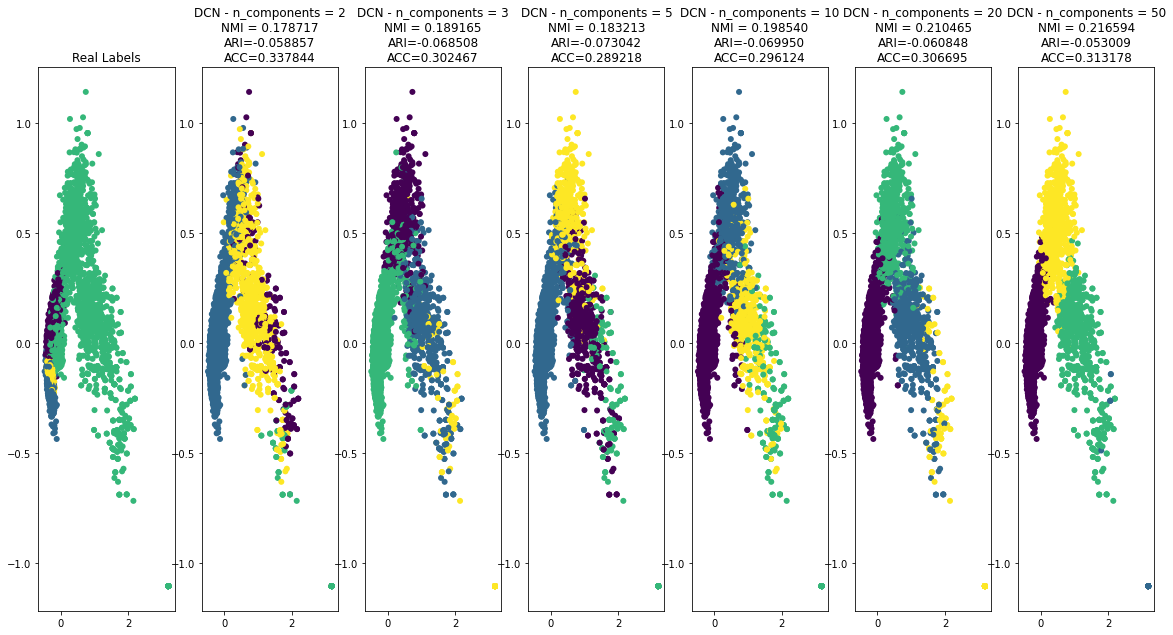

In [20]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

In [21]:
key = '{}_{}_dcn'.format(dataset, rep)
resluts[key] = (nmis, aris, accs)

#### DKM

In [22]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "classic4" with word2vec representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


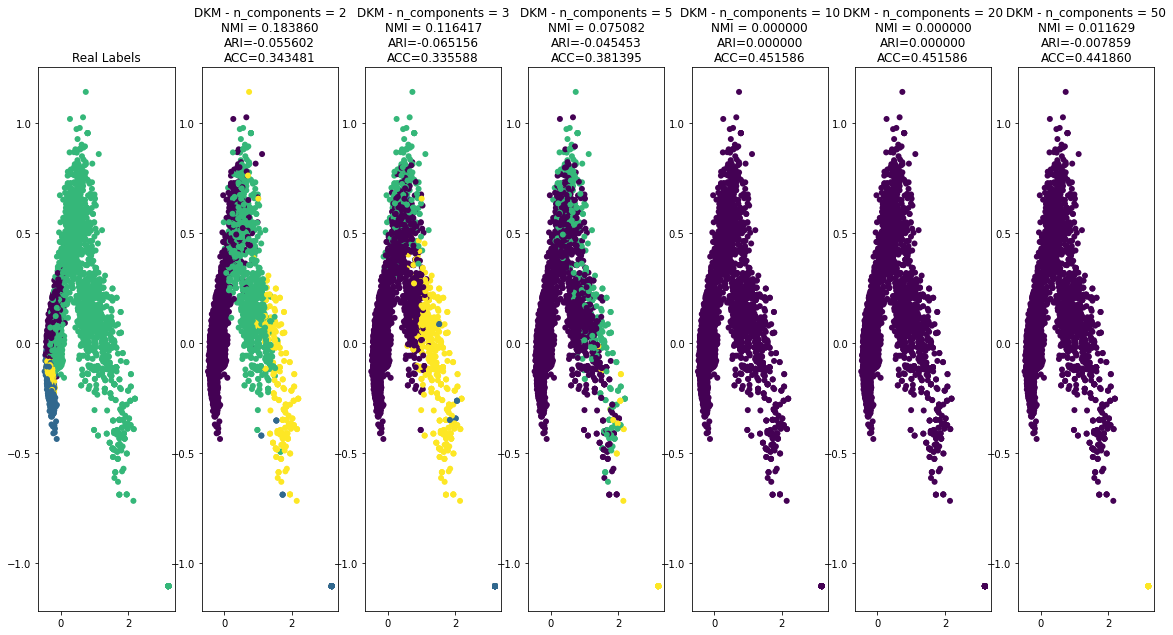

In [23]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

In [24]:
key = '{}_{}_dkm'.format(dataset, rep)
resluts[key] = (nmis, aris, accs)

### GloVe

In [25]:
X = classic4_glove
rep = 'GloVe'

#### DCN

In [26]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "classic4" with GloVe representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


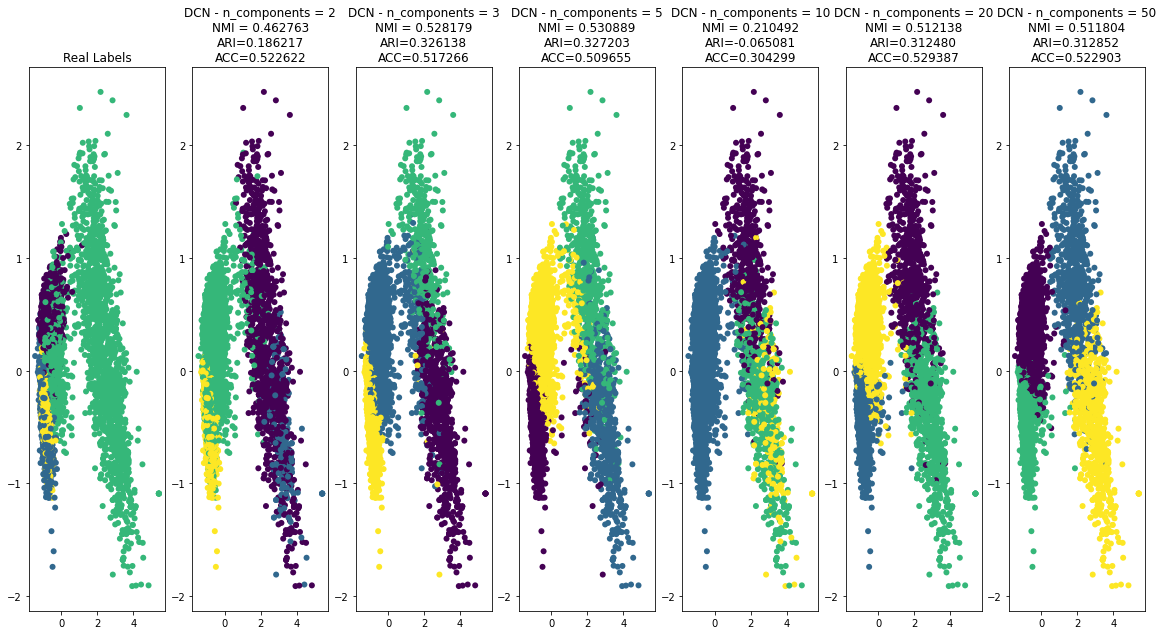

In [27]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

In [28]:
key = '{}_{}_dcn'.format(dataset, rep)
resluts[key] = (nmis, aris, accs)

#### DKM

In [29]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "classic4" with GloVe representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:31<00:00,  1.60s/it]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


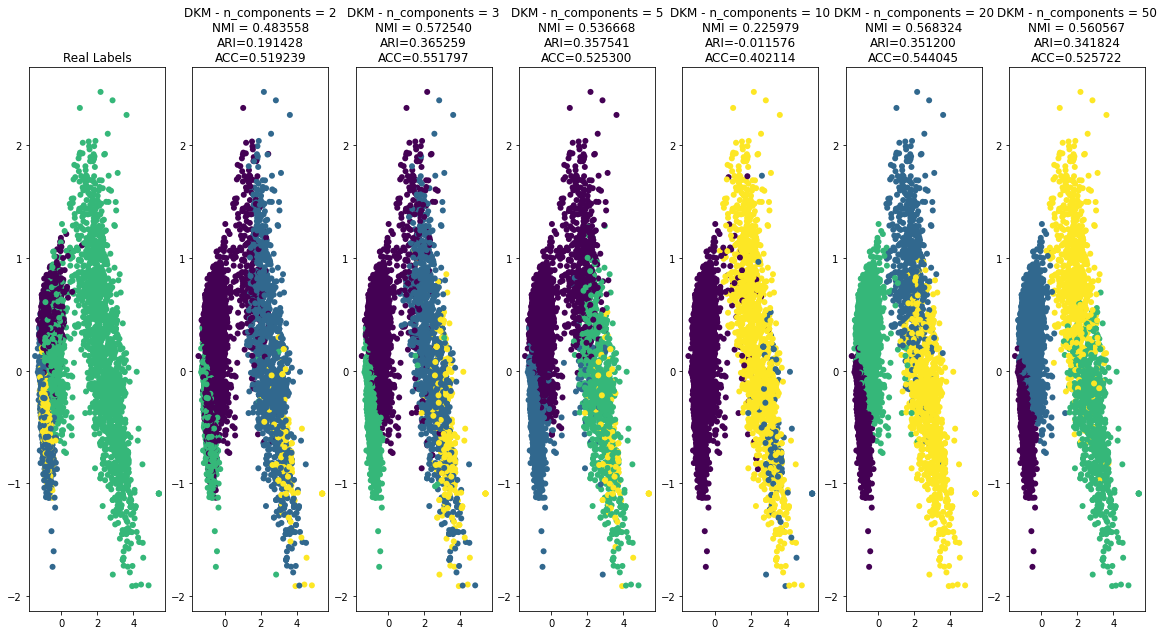

In [30]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

In [31]:
key = '{}_{}_dkm'.format(dataset, rep)
resluts[key] = (nmis, aris, accs)

## BBC

In [63]:
dataset = 'bbc'
k = k_bbc
labels = bbc_labels

### Word2Vec

In [64]:
X = bbc_word2vec
rep = 'word2vec'

#### DCN

In [65]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "bbc" with word2vec representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.41it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.41it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:14<00:00,  3.55it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.35it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.20it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.23it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:12<00:00,  3.93it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.03it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


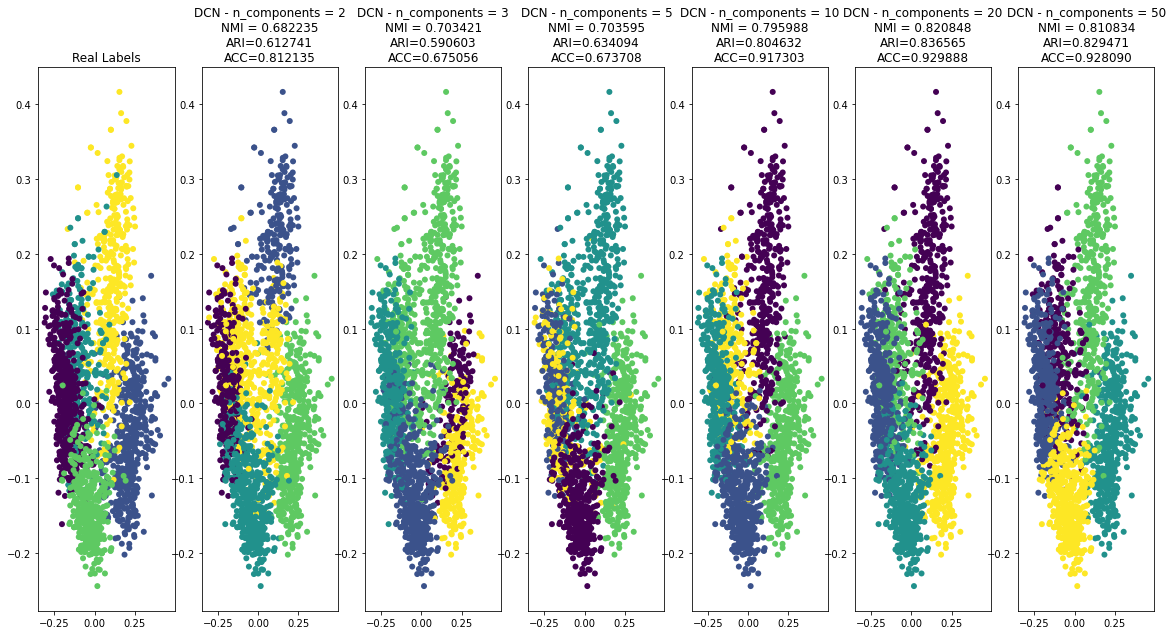

In [66]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

In [67]:
key = '{}_{}_dcn'.format(dataset, rep)
resluts[key] = (nmis, aris, accs)

#### DKM

In [68]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "bbc" with word2vec representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.67it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.70it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.97it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.65it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


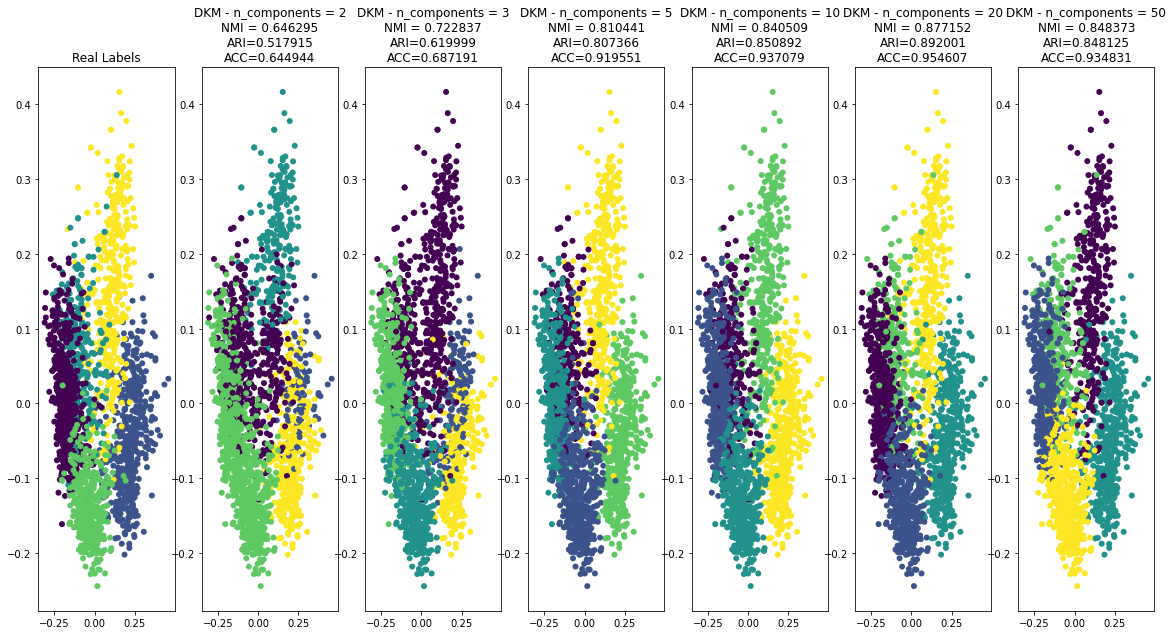

In [69]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

In [70]:
key = '{}_{}_dkm'.format(dataset, rep)
resluts[key] = (nmis, aris, accs)

### GloVe

In [71]:
X = bbc_word2vec
rep = 'GloVe'

#### DCN

In [72]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "bbc" with GloVe representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.40it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.32it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.30it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.53it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.58it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.16it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


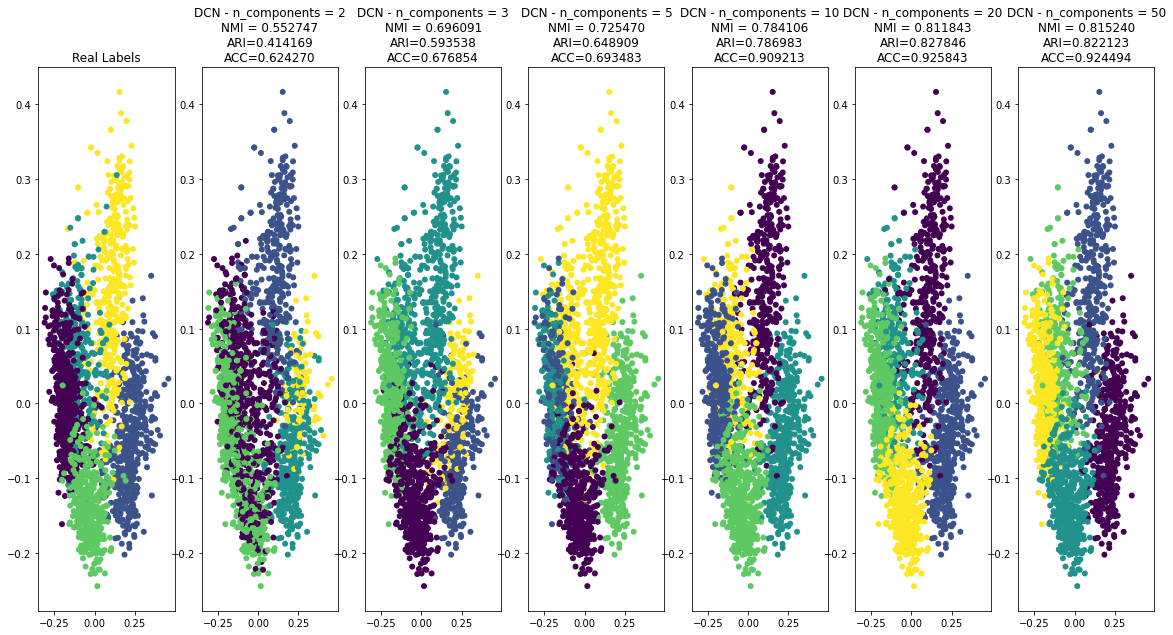

In [73]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

In [74]:
key = '{}_{}_dcn'.format(dataset, rep)
resluts[key] = (nmis, aris, accs)

#### DKM

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "bbc" with GloVe representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.32it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.98it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.78it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.69it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.69it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

In [ ]:
key = '{}_{}_dcn'.format(dataset, rep)
resluts[key] = (nmis, aris, accs)

## Tableaux

In [47]:
with open("/gdrive/My Drive/datasets/AMSD/projet_nadif/part2results.pkl", "wb") as results_file:
  pickle.dump(resluts, results_file)

In [49]:
resluts.keys()

dict_keys(['classic4_word2vec_dcn', 'classic4_word2vec_dkm', 'classic4_GloVe_dcn', 'classic4_GloVe_dkm', 'bbc_word2vec_dcn', 'bbc_word2vec_dkm'])

In [57]:
new_results = {}
for key, val in resluts.items():
  new_results[key] = {}
  nmi, ari, acc = val
  for inkey in nmi.keys():
    new_results[key][inkey] = {
        'nmi': nmi[inkey],
        'ari': ari[inkey],
        'acc': ari[inkey],
    }
  
results_dataframe = pd.DataFrame.from_dict({(i,j): new_results[i][j] 
                           for i in new_results.keys() 
                           for j in new_results[i].keys()},
                       orient='index')
results_dataframe 

nmi       ari       acc
classic4_word2vec_dcn DCN - n_components = 2   1.787169e-01 -0.058857 -0.058857
                      DCN - n_components = 3   1.891652e-01 -0.068508 -0.068508
                      DCN - n_components = 5   1.832127e-01 -0.073042 -0.073042
                      DCN - n_components = 10  1.985403e-01 -0.069950 -0.069950
                      DCN - n_components = 20  2.104646e-01 -0.060848 -0.060848
                      DCN - n_components = 50  2.165935e-01 -0.053009 -0.053009
classic4_word2vec_dkm DKM - n_components = 2   1.838601e-01 -0.055602 -0.055602
                      DKM - n_components = 3   1.164169e-01 -0.065156 -0.065156
                      DKM - n_components = 5   7.508186e-02 -0.045453 -0.045453
                      DKM - n_components = 10  1.728046e-15  0.000000  0.000000
                      DKM - n_components = 20  1.728046e-15  0.000000  0.000000
                      DKM - n_components = 50  1.162880e-02 -0.007859 -0.007859
classic4_GloVe_dcn    DCN - n_components = 2   4.627632e-01  0.186217  0.186217
                      DCN - n_components = 3   5.281794e-01  0.326138  0.326138
                      DCN - n_components = 5   5.308894e-01  0.327203  0.327203
                      DCN - n_components = 10  2.104923e-01 -0.065081 -0.065081
                      DCN - n_components = 20  5.121383e-01  0.312480  0.312480
                      DCN - n_components = 50  5.118044e-01  0.312852  0.312852
classic4_GloVe_dkm    DKM - n_components = 2   4.835578e-01  0.191428  0.191428
                      DKM - n_components = 3   5.725404e-01  0.365259  0.365259
                      DKM - n_components = 5   5.366678e-01  0.357541  0.357541
                      DKM - n_components = 10  2.259787e-01 -0.011576 -0.011576
                      DKM - n_components = 20  5.683235e-01  0.351200  0.351200
                      DKM - n_components = 50  5.605667e-01  0.341824  0.341824
bbc_word2vec_dcn      DKM - n_components = 2   6.296495e-01  0.502142  0.502142
                      DKM - n_components = 3   7.075469e-01  0.593924  0.593924
                      DKM - n_components = 5   7.384899e-01  0.641430  0.641430
                      DKM - n_components = 10  7.473953e-01  0.723278  0.723278
                      DKM - n_components = 20  8.645250e-01  0.879758  0.879758
                      DKM - n_components = 50  8.559013e-01  0.855549  0.855549
bbc_word2vec_dkm      DKM - n_components = 2   6.638588e-01  0.541812  0.541812
                      DKM - n_components = 3   7.053272e-01  0.610863  0.610863
                      DKM - n_components = 5   7.371571e-01  0.651601  0.651601
                      DKM - n_components = 10  8.432048e-01  0.858379  0.858379
                      DKM - n_components = 20  8.693609e-01  0.882185  0.882185
                      DKM - n_components = 50  8.360741e-01  0.836876  0.836876

In [62]:
new_results = {key: {inkey: {'nmi': nmi[inkey],'ari': ari[inkey],'acc': acc[inkey]} for inkey in nmi.keys()}  for key, (nmi, ari, acc) in resluts.items()}
results_dataframe = pd.DataFrame.from_dict({(i,j): new_results[i][j] 
                           for i in new_results.keys() 
                           for j in new_results[i].keys()},
                       orient='index')
results_dataframe

nmi       ari       acc
classic4_word2vec_dcn DCN - n_components = 2   1.787169e-01 -0.058857  0.337844
                      DCN - n_components = 3   1.891652e-01 -0.068508  0.302467
                      DCN - n_components = 5   1.832127e-01 -0.073042  0.289218
                      DCN - n_components = 10  1.985403e-01 -0.069950  0.296124
                      DCN - n_components = 20  2.104646e-01 -0.060848  0.306695
                      DCN - n_components = 50  2.165935e-01 -0.053009  0.313178
classic4_word2vec_dkm DKM - n_components = 2   1.838601e-01 -0.055602  0.343481
                      DKM - n_components = 3   1.164169e-01 -0.065156  0.335588
                      DKM - n_components = 5   7.508186e-02 -0.045453  0.381395
                      DKM - n_components = 10  1.728046e-15  0.000000  0.451586
                      DKM - n_components = 20  1.728046e-15  0.000000  0.451586
                      DKM - n_components = 50  1.162880e-02 -0.007859  0.441860
classic4_GloVe_dcn    DCN - n_components = 2   4.627632e-01  0.186217  0.522622
                      DCN - n_components = 3   5.281794e-01  0.326138  0.517266
                      DCN - n_components = 5   5.308894e-01  0.327203  0.509655
                      DCN - n_components = 10  2.104923e-01 -0.065081  0.304299
                      DCN - n_components = 20  5.121383e-01  0.312480  0.529387
                      DCN - n_components = 50  5.118044e-01  0.312852  0.522903
classic4_GloVe_dkm    DKM - n_components = 2   4.835578e-01  0.191428  0.519239
                      DKM - n_components = 3   5.725404e-01  0.365259  0.551797
                      DKM - n_components = 5   5.366678e-01  0.357541  0.525300
                      DKM - n_components = 10  2.259787e-01 -0.011576  0.402114
                      DKM - n_components = 20  5.683235e-01  0.351200  0.544045
                      DKM - n_components = 50  5.605667e-01  0.341824  0.525722
bbc_word2vec_dcn      DKM - n_components = 2   6.296495e-01  0.502142  0.635506
                      DKM - n_components = 3   7.075469e-01  0.593924  0.684494
                      DKM - n_components = 5   7.384899e-01  0.641430  0.710562
                      DKM - n_components = 10  7.473953e-01  0.723278  0.876854
                      DKM - n_components = 20  8.645250e-01  0.879758  0.948764
                      DKM - n_components = 50  8.559013e-01  0.855549  0.938427
bbc_word2vec_dkm      DKM - n_components = 2   6.638588e-01  0.541812  0.661573
                      DKM - n_components = 3   7.053272e-01  0.610863  0.689438
                      DKM - n_components = 5   7.371571e-01  0.651601  0.701573
                      DKM - n_components = 10  8.432048e-01  0.858379  0.939326
                      DKM - n_components = 20  8.693609e-01  0.882185  0.950112
                      DKM - n_components = 50  8.360741e-01  0.836876  0.930337